# Project Overview

This project analyzes a multi-country climate dataset (2000–2023) to explore relationships between temperature, emissions, rainfall, sea level rise, renewable energy usage, and extreme weather. Using machine learning, I build a Random Forest classifier to predict whether a country experiences a **high** number of extreme weather events based on environmental and economic indicators in a certain year.

## Research Questions
- How have climate indicators (temperature, CO2, sea level, rainfall) changed over time?
- Which factors are most associated with extreme weather events?
- Can we classify country-years as “High Extreme Events” vs “Not High”?
- How well does a Random Forest model perform (confusion matrix + ROC/AUC)?

## Tools & Methods
- **Python** (Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn)
- **JupyterLab**
- Data cleaning
- Random Forest classification
- Model evaluation (confusion matrix, ROC curve, AUC)

**Why does this matter?** Extreme weather events have real impacts on people, infrastructure, and ecosystems. Flooding, heat waves, storms, and drought can disrupt daily life and create major economic and public health costs. Understanding which factors are most associated with higher counts of extreme events (such as temperature, emissions, rainfall patterns, and land/energy use) can help support climate risk awareness and better long-term planning.

From a data science perspective, building a model that predicts “high extreme weather” years demonstrates how environmental indicators can be combined into a measurable, interpretable risk signal.

# Import Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Load the Dataset

In [15]:
data = pd.read_csv("/Users/cassidyriedel/Downloads/Resume Projects/climate_change_dataset.csv")
data.head()

,Year,Country,Avg Temperature (°C),CO2 Emissions (Tons/Capita),Sea Level Rise (mm),Rainfall (mm),Population,Renewable Energy (%),Extreme Weather Events,Forest Area (%)
0,2006,UK,8.9,9.3,3.1,1441,530911230,20.4,14,59.8
1,2019,USA,31.0,4.8,4.2,2407,107364344,49.2,8,31.0
2,2014,France,33.9,2.8,2.2,1241,441101758,33.3,9,35.5
3,2010,Argentina,5.9,1.8,3.2,1892,1069669579,23.7,7,17.7
4,2007,Germany,26.9,5.6,2.4,1743,124079175,12.5,4,17.4


# Clean Dataset

In [16]:
data = data.drop_duplicates()
num_cols = [
    "Year",
    "Avg Temperature (°C)",
    "CO2 Emissions (Tons/Capita)",
    "Sea Level Rise (mm)",
    "Rainfall (mm)",
    "Population",
    "Renewable Energy (%)",
    "Extreme Weather Events",
    "Forest Area (%)"
]
data.isna().sum()

Year                           0
Country                        0
Avg Temperature (°C)           0
CO2 Emissions (Tons/Capita)    0
Sea Level Rise (mm)            0
Rainfall (mm)                  0
Population                     0
Renewable Energy (%)           0
Extreme Weather Events         0
Forest Area (%)                0
dtype: int64

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         1000 non-null   int64  
 1   Country                      1000 non-null   object 
 2   Avg Temperature (°C)         1000 non-null   float64
 3   CO2 Emissions (Tons/Capita)  1000 non-null   float64
 4   Sea Level Rise (mm)          1000 non-null   float64
 5   Rainfall (mm)                1000 non-null   int64  
 6   Population                   1000 non-null   int64  
 7   Renewable Energy (%)         1000 non-null   float64
 8   Extreme Weather Events       1000 non-null   int64  
 9   Forest Area (%)              1000 non-null   float64
dtypes: float64(5), int64(4), object(1)
memory usage: 78.3+ KB


# Explore the Data

## Figure 1. EDA

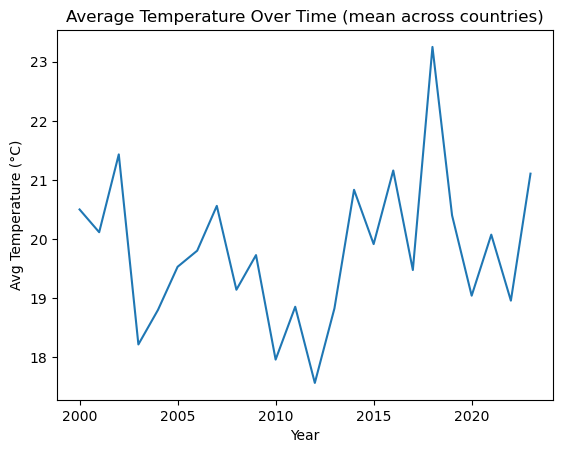

In [20]:
plt.figure()
data.groupby("Year")["Avg Temperature (°C)"].mean().plot()
plt.title("Average Temperature Over Time (mean across countries)")
plt.xlabel("Year")
plt.ylabel("Avg Temperature (°C)")
plt.show()

**Figure 1.** Mean annual average temperature across all countries in the dataset (2000–2023). Each point represents the average of “Avg Temperature (°C)” for all countries in a given year, showing year-to-year variability and potential warming in later years.

## Figure 2. Histogram + KDE (distribution of temperatures)

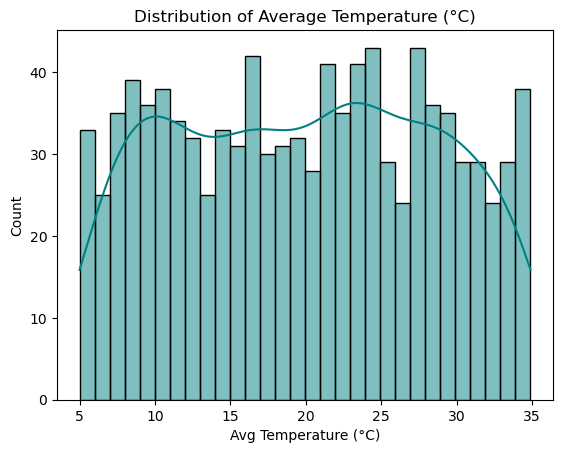

In [22]:
plt.figure()
sns.histplot(data["Avg Temperature (°C)"], bins=30, kde=True, color="teal")
plt.title("Distribution of Average Temperature (°C)")
plt.xlabel("Avg Temperature (°C)")
plt.ylabel("Count")
plt.show()

**Figure 2.** Distribution of average temperatures across all country-years, showing the overall range and where most observations fall.

## Figure 3. Scatterplot (Europe CO₂ vs Temperature) + trendline

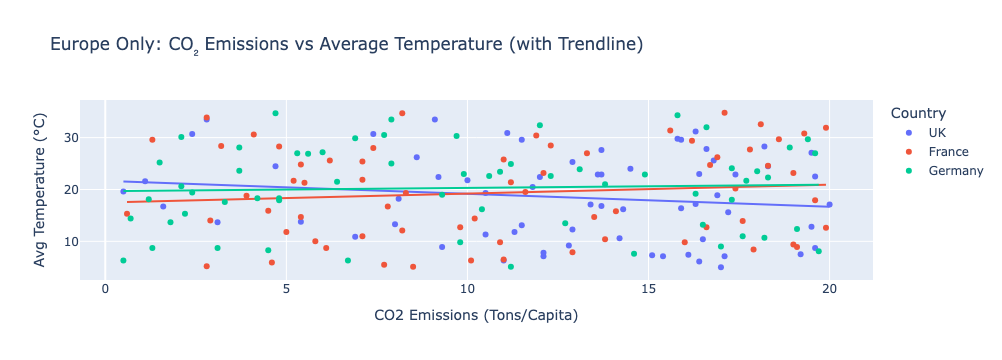

In [31]:
europe = data[data["Country"].isin(["UK", "France", "Germany"])]

fig = px.scatter(
    europe,
    x="CO2 Emissions (Tons/Capita)",
    y="Avg Temperature (°C)",
    color="Country",
    hover_data=["Year", "Sea Level Rise (mm)", "Rainfall (mm)", "Renewable Energy (%)", "Forest Area (%)"],
    trendline="ols",
    title="Europe Only: CO₂ Emissions vs Average Temperature (with Trendline)"
)
fig.show()

**Figure 3.** Interactive scatterplot for European countries (UK, France, Germany) showing the relationship between CO₂ emissions per capita and average temperature across country-years (2000–2023). Points are colored by country, hover reveals year and other indicators, and the fitted OLS trendline summarizes the overall direction of the relationship within this subset.

## Figure 4. Violin plot (Extreme weather events by High/Not High label)

### Create Label

In [34]:
threshold = data["Extreme Weather Events"].median()
data["HighExtreme"] = (data["Extreme Weather Events"] > threshold).astype(int)

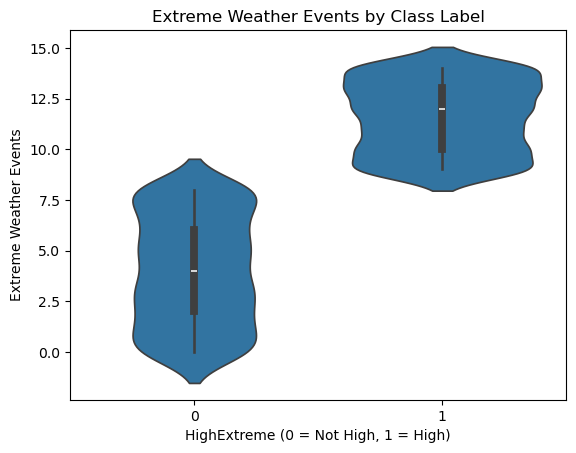

In [35]:
plt.figure()
sns.violinplot(
    data=data,
    x="HighExtreme",
    y="Extreme Weather Events"
)
plt.title("Extreme Weather Events by Class Label")
plt.xlabel("HighExtreme (0 = Not High, 1 = High)")
plt.ylabel("Extreme Weather Events")
plt.show()

**Figure 4.** Violin plot comparing the distribution of extreme weather events for the “Not High” vs “High” classes used in the Random Forest model.

# Build Features (X) & Label (y)

In [36]:
features = [
    "Year",
    "Avg Temperature (°C)",
    "CO2 Emissions (Tons/Capita)",
    "Sea Level Rise (mm)",
    "Rainfall (mm)",
    "Population",
    "Renewable Energy (%)",
    "Forest Area (%)"
]

X = pd.get_dummies(data[features + ["Country"]], columns=["Country"], drop_first=True)
y = data["HighExtreme"]

# Train/Test Split

In [38]:
df_clean = data.copy()
X = pd.get_dummies(df_clean[features + ["Country"]], columns=["Country"], drop_first=True)
y = df_clean["HighExtreme"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Random Forest Model

In [54]:
rf = RandomForestClassifier(n_estimators=400, random_state=42)
rf.fit(X_train, y_train)

,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Confusion Matrix

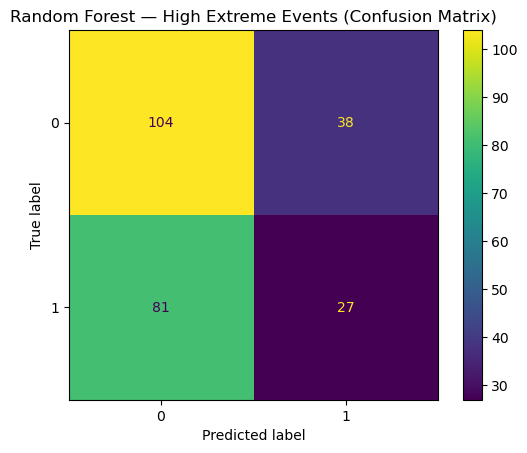

In [40]:
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Random Forest — High Extreme Events (Confusion Matrix)")
plt.show()

# ROC Curve

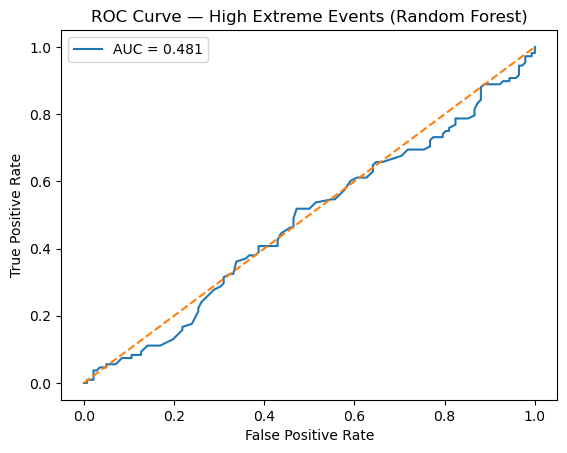

In [42]:
y_proba = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve — High Extreme Events (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Baseline Random Forest achieved AUC ≈ 0.48, indicating limited predictive signal with the initial label definition and split strategy. Next, I improved the experimental setup by using time-based splits and alternative label definitions (top quartile / within-country) to better reflect meaningful ‘extreme’ conditions.

# Redefine "HighExtreme" 

In [48]:
df_clean = data.sort_values(["Country", "Year"]).reset_index(drop=True)

# Country-relative label: 1 if this year is above that country's median
df_clean["HighExtreme"] = (
    df_clean["Extreme Weather Events"] >
    df_clean.groupby("Country")["Extreme Weather Events"].transform("median")
).astype(int)

df_clean["HighExtreme"].value_counts()

HighExtreme
0    566
1    434
Name: count, dtype: int64

# Improved Random Forest Model

In [50]:
features = [
    "Year",
    "Avg Temperature (°C)",
    "CO2 Emissions (Tons/Capita)",
    "Sea Level Rise (mm)",
    "Rainfall (mm)",
    "Population",
    "Renewable Energy (%)",
    "Forest Area (%)"
]

X = pd.get_dummies(df_clean[features + ["Country"]], columns=["Country"], drop_first=True)
y = df_clean["HighExtreme"]

# time-based split (overall)
df_time = df_clean.sort_values("Year").reset_index(drop=True)
X = X.loc[df_time.index]
y = y.loc[df_time.index]

split = int(len(df_time) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight="balanced")
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
roc_auc = auc(*roc_curve(y_test, y_proba)[:2])
roc_auc

0.5160613810741688

# Improved Confusion Matrix

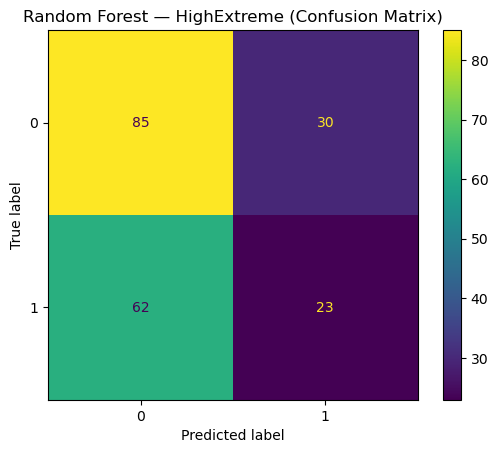

In [52]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Random Forest — HighExtreme (Confusion Matrix)")
plt.show()

Confusion matrix for the Random Forest classifier predicting HighExtreme (years with above-median extreme weather events relative to each country’s baseline). The matrix summarizes correct vs. incorrect classifications on the test set, showing true negatives/positives and where the model most often misclassifies high-extreme years.

# Improved ROC Curve

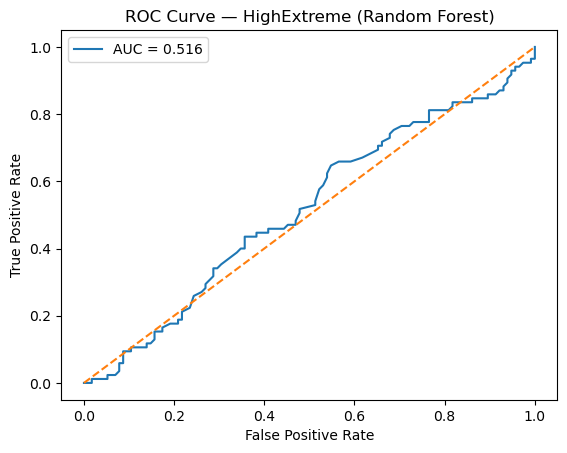

In [57]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve — HighExtreme (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

ROC curve for the Random Forest model predicting HighExtreme after redefining the label relative to each country’s median extreme-weather baseline. The model achieves an AUC of 0.516, indicating slight improvement over random guessing and limited but measurable predictive signal in the available features.

# Feature Importances (top 12)

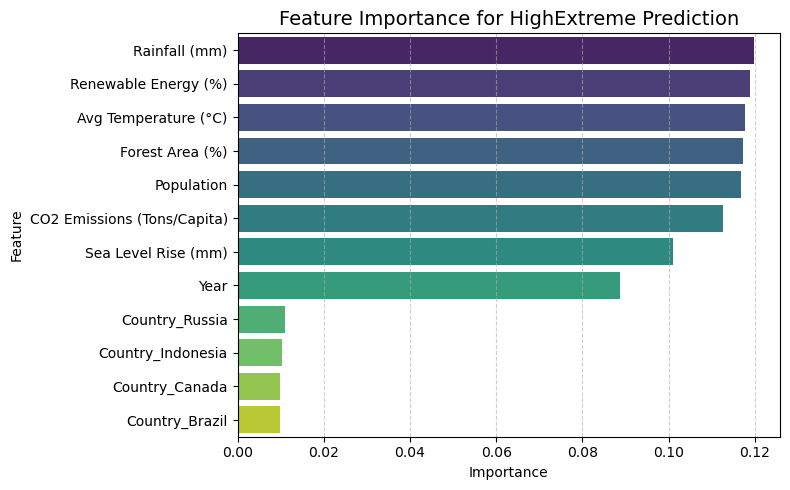

In [59]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=importances.head(12).values,
    y=importances.head(12).index,
    hue=importances.head(12).index,
    palette="viridis",
    legend=False
)

plt.title("Feature Importance for HighExtreme Prediction", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.xlim(left=0)
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Random Forest feature importance rankings for predicting HighExtreme (above-country-median extreme weather years). Rainfall, renewable energy share, and average temperature contribute the most predictive signal, followed by forest area, population, and CO₂ emissions; several country dummy variables have smaller but nonzero influence.

# Interpretation

The feature importance plot suggests that **rainfall, renewable energy share, and average temperature** contribute the most to the model’s predictions, with additional signal from forest area, population, and CO₂ emissions. Because Random Forest feature importance reflects how often a feature helps split the data, it should be interpreted as **relative influence** rather than proof of causation.

# Limitations

- **AUC is modest (~0.52)**, meaning the features provide limited predictive signal for above-baseline extreme event years.
- The dataset is **aggregated at the country-year level**, which can hide regional variability (storms and floods are local).
- "Extreme Weather Events" is treated as a single count, but different event types may have different drivers.
- This analysis is **correlational** and does not imply causation.

# Reflection

This project showed me that building a model is not just about picking an algorithm—it’s about how the problem is defined. My first attempt at predicting “HighExtreme” using a global threshold produced near-random results, which forced me to step back and rethink the label. Redefining “HighExtreme” relative to each country’s baseline created a more meaningful target and improved performance (AUC increased to ~0.52).

I also learned how important evaluation choices are. Using ROC/AUC and confusion matrices helped me see where the model struggled (especially correctly identifying HighExtreme cases), and feature importance gave me a way to explain what the model relied on. Even though the model’s performance was modest, the process was valuable because it highlighted dataset limitations and the need for higher-resolution climate and hazard data to make stronger predictions.

Overall, this project strengthened my ability to clean data, design a defensible target variable, build and evaluate a machine learning model, and communicate results honestly—skills I want to bring to an internship in environmental data science.